## ================================================================
## BRIAN2 SIMULATION OF A RECURRENT EXCITATORY NEURONAL NETWORK
## ================================================================
This notebook simulates current-driven excitatory neurons with
spike-frequency adaptation (**AHP**) and short-term synaptic plasticity.
The outputs are used to generate panels for Supplementary Figures S2 and S3.

In [ ]:
# ------------------------------------------------
# Import required packages
# ------------------------------------------------

!pip install brian2 -q
from brian2 import *
import numpy as np
from time import time
set_device('cpp_standalone', build_on_run=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.3 MB/s eta 0:00:00


In [ ]:

## ================================================================
## Parameter Setting
## ================================================================
# Define neuron intrinsic properties, synaptic parameters,
# and short-term plasticity constants.

Ne = 100                            # Number of excitatory neurons
El = -39.2 * mV                     # Nernst potential of leaky ions
EK = -80 * mV                       # Nernst potential of potassium
ENa = 70 * mV                       # Nernst potential of sodium
VT = -30.4*mV                       # alters firing threshold of neurons
E_ampa = 0*mV                       # reverse synaptic potential
tau_ampa = 2*ms                     # synaptic time constant AMPA
E_nmda = 0 * mV                     # Nernst potentials of synaptic channels
taud_nmda = 100 * ms                # decay time constant of nmda conductance
taur_nmda = 2 * ms                  # rise time constant of nmda conductance
tau_d = 800 * ms                    # recovery time constant of synaptic depression
grid_dist = 45 * umeter
Vmax = 25*mm/second                 # Axonal conduction velocity
fD = 0.0075                         # magnitude of depression
g_nmda = 0.01*nS                    # conductance increment when spike on pre
g_ampa = 0.35*nS                    # conductance increment when spike on pre
sigma = 0*mV                        # standard deviation of the noisy voltage fluctuations


E_AHP = EK
g_AHP_pm = 10*nS
tau_Ca = 6000 * ms                  # recovery time constant AHP channels
alpha_Ca = 0.0002                   # strength of the spike-frequency adaptation

S = 10

tau_f = 50 * ms                     # recovery time constant of synaptic facilitation
x0_d = 1                            # steady-state release probability (depression)
x0_f = 0.1                          # steady-state release probability (facilitation)
fF = 0

## ================================================================
## Definition of Cell Intrinsic and Synaptic Equations
## ================================================================
# Hodgkin–Huxley-like dynamics with AHP and synaptic currents.
# Includes short-term plasticity (facilitation and depression).

eqs = '''
dV/dt = (noise + -gl*(V-El)-g_na*(m**3)*h*(V-ENa)-g_kd*(n**4)*(V-EK)-I_syn+I+I_AHP)/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
dhp/dt = 0.128*exp((17.*mV-V+VT)/(18.*mV))/ms*(1.-hp)-4./(1+exp((30.*mV-V+VT)/(5.*mV)))/ms*h : 1
alpha_m = 0.32*(mV**-1)*4*mV/exprel((13*mV-V+VT)/(4*mV))/ms : Hz
beta_m = 0.28*(mV**-1)*5*mV/exprel((V-VT-40*mV)/(5*mV))/ms : Hz
alpha_h = 0.128*exp((17*mV-V+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-V+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*5*mV/exprel((15*mV-V+VT)/(5*mV))/ms : Hz
beta_n = .5*exp((10*mV-V+VT)/(40*mV))/ms : Hz
noise = sigma*(2*gl*Cm)**.5*randn()/sqrt(dt) : amp (constant over dt)
I_AHP = -g_AHP*Ca*(V-E_AHP) : amp
dCa/dt = - Ca / tau_Ca : 1
I_syn = I_ampa+I_nmda : amp
I_ampa = g_ampa*(V-E_ampa)*s_ampa : amp
ds_ampa/dt = -s_ampa/tau_ampa : 1
I_nmda = g_nmda*(V-E_nmda)*s_nmda_tot/(1+exp(-0.062*V/mV)/3.57) : amp
s_nmda_tot : 1
I : amp
x : meter
y : meter
g_AHP : siemens
area : meter**2
Cm = (1*uF*cm**-2) * area : farad
g_na = (50*mS*cm**-2) * area : siemens
g_kd = (5*mS*cm**-2) * area : siemens
gl = (0.3*mS*cm**-2) * area : siemens
'''

eqs_synE_model = '''
s_nmda_tot_post = w * S * s_nmda * x_d * x_f : 1 (summed)
ds_nmda/dt = -s_nmda/(taud_nmda)+x_nmda*(1-s_nmda)/taur_nmda  : 1 (clock-driven)
dx_nmda/dt = -x_nmda/(taur_nmda) : 1 (clock-driven)
dx_d/dt = (x0_d-x_d)/tau_d :1 (clock-driven)
dx_f/dt = (x0_f-x_f)/tau_f :1 (clock-driven)
w : 1
'''

eqs_synE_onpre = '''
s_ampa += w * S * x_d * x_f
x_nmda += 1
x_d *= (1-fD)
x_f += fF*(1-x_f)
'''


## ================================================================
## Network Construction
## ================================================================
# Create neuron group, assign spatial positions, and set up synapses with
# short-term plasticity and distance-dependent delays.

cellsExc = NeuronGroup(Ne,
                    model=eqs,
                    threshold='V>0*mV',
                    reset='Ca += alpha_Ca',
                    refractory=2*ms,
                    method='exponential_euler')
cellsExc.area = 220*um**2  # np.random.uniform(low=170, high=270, size=Ne)*um**2
cellsExc.V = El
cellsExc.g_AHP = g_AHP_pm

# Spatial distribution 
cellsExc.x = '(i % int(sqrt(Ne))) * grid_dist'
cellsExc.y = '(i // int(sqrt(Ne))) * grid_dist'

# Load predefined structural connectivity (source/target pairs)
sources = np.load('source_SF_RND_a2.npy')
target = np.load('target_SF_RND_a2.npy')

syn_EE = Synapses(cellsExc, cellsExc, model=eqs_synE_model, on_pre=eqs_synE_onpre, method='euler')
syn_EE.connect(i=sources, j=target)
syn_EE.w = cellsExc.area[target]/(300*um**2)

# Distance-dependent synaptic delays
syn_EE.delay = '(sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2))/Vmax'



# ================================================================
# Simulation Execution
# ================================================================
# Run the simulation for a specified duration and record spike times.


spikes = SpikeMonitor(cellsExc)

dur = 65*second
run(dur)
device.build(run=False)

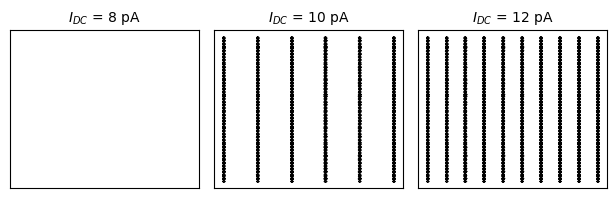

In [ ]:
## ================================================================
## Analysis, Visualization,  and Saving
## ================================================================
# Compute instantaneous firing rates (IFR), smooth them,
# and generate raster plots and STH figures.


# Raster plots for DC currents
fig, axes = subplots(1, 3, figsize=(15.92/2.54, 5.3/2.54))
I_dc = [8,10,12]

for ax, sp, idc in zip(axes.flat, results, I_dc):
  ax.set_title(fr'$I_{{DC}}$ = {idc:.0f} pA', fontsize=10)
  ax.scatter(sp[0], sp[1], s=0.003, color='k')
  ax.set_xticks(ticks=[], labels=[])
  ax.set_yticks(ticks=[], labels=[])

fig.tight_layout()
fig.savefig('Raster_current_driven_with_ahp.tif', dpi=600)

# Compute spike counts per time bin and smooth with a 10 ms moving average to obtain the instantaneous firing rate (IFR)
timestamps, counts = np.unique(np.asarray(sp_t/defaultclock.dt, dtype=int), return_counts=True)

ifr = np.zeros(600_000)
ifr[timestamps] = counts

ifr_10ms = np.convolve(ifr, np.ones(1000)/1000, mode='valid')

# Plot normalized spike-triggered histogram (STH)
  # fig, ax = subplots(1, 1, figsize=(5.31/2.54, 5.31/2.54))

  # ax.set_title(fr'$I_{{DC}}$ = {idc:.0f} pA', fontsize=10)
  # ax.plot(np.linspace(0, 2, 20_000), ifr_10ms[50_000:70_000]/np.amax(ifr_10ms))
  # ax.set_xticks(ticks=[0, 1, 2], labels=[0, 1, 2])
  # ax.set_yticks(ticks=[0, 0.5, 1], labels=[0, 0.5, 1])
  # ax.set_ylabel('Normalized STH', fontsize=8)
  # ax.set_xlabel('Time (s)', fontsize=8)

  # ax.set_xlim(0,2)
  # ax.set_ylim(-0.05, 1)
  # ax.spines[['top', 'right']].set_visible(False)
  # fig.tight_layout()
  # fig.savefig('STH_current_driven_w_ahp.tif', dpi=600)
fig, ax = plt.subplots(1, 1, figsize=(7.96/2.54, 7.96/2.54))
color = 'tab:blue'

  #  ax.plot(np.arange(len(sth))*1000/freqSam, sth/np.max(sth), color=color, linewidth=1.5)
ax.plot(np.linspace(0, 2, 20_000), ifr_10ms[50_000:70_000]/np.amax(ifr_10ms), color=color, linewidth=1.5)
  # ax.plot(start_rise*1000/freqSam, sth[start_rise]/np.max(sth), 'ko', markersize=2)
  # ax.plot(np.arange(start_rise, end_rise)*1000/freqSam, fitted_rise/np.max(sth), '--k', linewidth=1)
  # ax.plot(end_rise*1000/freqSam, sth[end_rise]/np.max(sth), 'ko', markersize=2)
  # ax.plot(start_decay*1000/freqSam, sth[start_decay]/np.max(sth), 'ko', markersize=2)
  # ax.plot(np.arange(start_decay, end_decay)*1000/freqSam, fitted_decay, '--k', linewidth=1)
  # ax.plot(end_decay*1000/freqSam, sth[end_decay]/np.max(sth), 'ko', markersize=2)
ax.set_xlabel('Time (seconds)', fontsize=8)
ax.set_ylabel('Normalized STH', fontsize=8)
  # ax.set_title('In Vitro', fontsize=10)
ax.spines[['right', 'top']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1)
ax.tick_params(width=1)
ax.set_xticks(ticks=[0,1,2], labels=[0,1,2], fontsize=6)
ax.set_xlim(0,2)
ax.set_ylim(-0.01,1.1)
ax.spines['left'].set_bounds(0, 1)
ax.set_yticks(ticks=[0,0.5,1], labels=[0,0.5,1], fontsize=6)

fig.tight_layout()
fig.savefig('sth_AHP.tif', format="tiff", dpi=600)
# plt.show()